### **1. Business Understanding**

Proyek ini bertujuan membangun sistem deteksi suara sederhana yang mampu mengenali dua perintah utama, yaitu *“buka”* dan *“tutup”*, serta membedakan dua pengguna yang telah dilatih. Sistem juga dapat menolak suara orang lain dengan hasil *unknown*.

Secara teknis, sistem menggunakan ekstraksi fitur suara (spectral, temporal, dan statistik) dan model klasifikasi yang diekspor ke file **.pkl**. Aplikasi dapat menerima input audio, mengekstrak fitur, mengklasifikasikan hasil (*buka*, *tutup*, atau *unknown*), dan menampilkan respons sesuai perintah.

Keberhasilan sistem diukur dengan **akurasi minimal 85%** pada data uji, dengan kemampuan mengenali dua pengguna dan menolak suara asing di luar data pelatihan.



### **2. Data Understanding**

- buka: 100 file 
- tutup: 80 file 

Bisa dilakukan oversampling (SMOTE) agar seimbang dan Format file .wav dengan durasi pendek (0.5–1 detik).

**Proses augmentasi data dilakukan untuk menambah variasi data suara agar model dapat mengenali pola dengan lebih baik, terutama karena jumlah data suara teman lebih sedikit dibanding data suara saya. Teknik augmentasi yang digunakan meliputi penambahan noise, perubahan pitch (naik dan turun), perubahan kecepatan (time-stretch), serta pergeseran waktu (time-shift). Setiap file suara asli diolah menjadi beberapa versi baru menggunakan kombinasi teknik tersebut. Hasilnya, jumlah data suara meningkat secara signifikan tanpa mengubah karakteristik utama suara.**

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import soundfile as sf
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import RobustScaler

In [10]:
input_dir = r"dataset/train/saya/tutup"
output_dir = r"dataset/data_augmented"

os.makedirs(output_dir, exist_ok=True)
count = 0

for file in os.listdir(input_dir):
    if file.lower().endswith(".wav"):
        file_path = os.path.join(input_dir, file)

        try:
            y, sr = librosa.load(file_path, sr=None)
            filename = os.path.splitext(file)[0]

            y_pitch = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2)
            sf.write(os.path.join(output_dir, f"{filename}_pitch.wav"), y_pitch, sr)
            count += 1

            y_pitch_up = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=3)
            sf.write(os.path.join(output_dir, f"{filename}_pitch_up.wav"), y_pitch_up, sr)
            count += 1

            y_gain_up = np.clip(y * 1.2, -1.0, 1.0)
            sf.write(os.path.join(output_dir, f"{filename}_gain_up.wav"), y_gain_up, sr)
            count += 1


            print(f"✅ {filename} berhasil diaugmentasi ({count} file total sejauh ini)")

        except Exception as e:
            print(f"❌ Gagal proses {file}: {e}")

print(f"\n✅ Augmentasi selesai! Total file baru: {count}")
print(f"Hasil disimpan di: {os.path.abspath(output_dir)}")


✅ tutup_1 (2) berhasil diaugmentasi (3 file total sejauh ini)
✅ tutup_1 (2)_gain_up berhasil diaugmentasi (6 file total sejauh ini)
✅ tutup_1 (2)_pitch berhasil diaugmentasi (9 file total sejauh ini)
✅ tutup_1 (2)_pitch_up berhasil diaugmentasi (12 file total sejauh ini)
✅ tutup_1 berhasil diaugmentasi (15 file total sejauh ini)
✅ tutup_10 (2) berhasil diaugmentasi (18 file total sejauh ini)
✅ tutup_10 (2)_gain_up berhasil diaugmentasi (21 file total sejauh ini)
✅ tutup_10 (2)_pitch berhasil diaugmentasi (24 file total sejauh ini)
✅ tutup_10 (2)_pitch_up berhasil diaugmentasi (27 file total sejauh ini)
✅ tutup_10 berhasil diaugmentasi (30 file total sejauh ini)
✅ tutup_11 (2) berhasil diaugmentasi (33 file total sejauh ini)
✅ tutup_11 (2)_gain_up berhasil diaugmentasi (36 file total sejauh ini)
✅ tutup_11 (2)_pitch berhasil diaugmentasi (39 file total sejauh ini)
✅ tutup_11 (2)_pitch_up berhasil diaugmentasi (42 file total sejauh ini)
✅ tutup_11 berhasil diaugmentasi (45 file total sej

#### **Ekstraksi Fitur**

Proses ekstraksi fitur dilakukan dengan mengombinasikan tiga jenis fitur utama, yaitu spectral, temporal, dan statistical features. Kombinasi ini membantu sistem mengenali karakteristik unik dari setiap suara, seperti frekuensi, pola waktu, serta nilai rata-rata atau variasi energi sinyal, sehingga model dapat membedakan perintah “buka” dan “tutup” dengan lebih akurat.

In [6]:
def extract_features(file_path):
    try:
        # === Load Audio ===
        y, sr = librosa.load(file_path, sr=None)
        
        # === Temporal Features ===
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
        rms = np.mean(librosa.feature.rms(y=y))
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # === Spectral Features ===
        spec_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spec_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        spec_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
        spec_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        
        # === Mel-Frequency Cepstral Coefficients (MFCCs) ===
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)
        
        # === Statistical Features ===
        mean_val = np.mean(y)
        std_val = np.std(y)
        skew_val = skew(y)
        kurt_val = kurtosis(y)
        
        # === Combine All Features ===
        features = {
            'zcr': zcr,
            'rms': rms,
            'tempo': tempo,
            'spec_centroid': spec_centroid,
            'spec_bandwidth': spec_bandwidth,
            'spec_contrast': spec_contrast,
            'spec_rolloff': spec_rolloff,
            'mean': mean_val,
            'std': std_val,
            'skew': skew_val,
            'kurtosis': kurt_val
        }
        
        for i, val in enumerate(mfccs_mean):
            features[f'mfcc_{i+1}'] = val
        
        return features

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

In [7]:
base_dir = "dataset/train"  
data = []

for speaker in os.listdir(base_dir):
    speaker_path = os.path.join(base_dir, speaker)
    if not os.path.isdir(speaker_path):
        continue

    for label in os.listdir(speaker_path):
        label_path = os.path.join(speaker_path, label)
        if not os.path.isdir(label_path):
            continue

        for file_name in tqdm(os.listdir(label_path), desc=f"{speaker}-{label}"):
            if file_name.endswith(".wav"):
                file_path = os.path.join(label_path, file_name)
                features = extract_features(file_path)
                if features:
                    features['speaker'] = speaker
                    features['label'] = label
                    features['file_path'] = file_path
                    data.append(features)


teman-buka: 100%|██████████| 83/83 [00:03<00:00, 22.71it/s]


In [8]:
df = pd.DataFrame(data)
output_csv = "ekstraksi_fitur_suara.csv"
df.to_csv("ekstraksi_fitur_suara.csv", index=False)

### **3. Exploratory Data Analysis (EDA)**

Tahap ini bertujuan untuk memahami karakteristik dan distribusi data sebelum proses pelatihan model. Analisis dilakukan dengan menghitung jumlah file pada setiap kelas (buka dan tutup), memeriksa durasi rata-rata tiap file audio, serta memastikan keseragaman sampling rate dan format file agar data konsisten dan siap diproses lebih lanjut.

In [9]:
df = pd.read_csv("ekstraksi_fitur_suara.csv")
print("Ukuran dataset:", df.shape)
print("\nContoh 5 data teratas:")
display(df.head())

Ukuran dataset: (369, 27)

Contoh 5 data teratas:


,zcr,rms,tempo,spec_centroid,spec_bandwidth,spec_contrast,spec_rolloff,mean,std,skew,...,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,speaker,label,file_path
0,0.031096,0.077008,[303.99816176],1971.563441,3212.080263,19.746896,3617.578125,0.000004,0.107378,1.221425,...,0.993255,0.251915,5.557098,-7.657348,6.288062,0.897784,-12.901854,saya,buka,dataset/train\saya\buka\buka_1 (2).wav
1,0.024106,0.095067,[166.70866935],1946.156207,3328.419830,19.148309,3524.157151,0.000151,0.126469,0.824466,...,6.570087,5.286549,7.126675,-8.592355,1.969883,11.492401,-14.198255,saya,buka,dataset/train\saya\buka\buka_1.wav
2,0.028622,0.051543,[287.109375],1961.685899,3202.618051,19.316381,3983.184425,-0.000011,0.074131,1.364824,...,10.303352,4.179083,-0.241050,-2.061037,13.400628,1.011641,-20.812042,saya,buka,dataset/train\saya\buka\buka_10 (2).wav
3,0.028851,0.065145,[198.76802885],1786.679298,3059.365229,19.464844,3177.469675,0.000029,0.087380,1.388188,...,9.829638,-2.206978,-9.136992,-13.432102,-1.176778,6.743266,-7.540455,saya,buka,dataset/train\saya\buka\buka_10.wav
4,0.036051,0.080667,[120.18531977],2149.597011,3334.384832,19.373303,4163.803711,0.000009,0.118984,0.802815,...,8.861814,14.030582,-7.373435,-1.762983,12.971463,6.720855,-18.296100,saya,buka,dataset/train\saya\buka\buka_11 (2).wav


In [10]:
print("\nDaftar kolom:")
print(df.columns.tolist())


Daftar kolom:
['zcr', 'rms', 'tempo', 'spec_centroid', 'spec_bandwidth', 'spec_contrast', 'spec_rolloff', 'mean', 'std', 'skew', 'kurtosis', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'speaker', 'label', 'file_path']


In [11]:
print("\nInformasi dataset:")
df.info()


Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zcr             369 non-null    float64
 1   rms             369 non-null    float64
 2   tempo           369 non-null    object 
 3   spec_centroid   369 non-null    float64
 4   spec_bandwidth  369 non-null    float64
 5   spec_contrast   369 non-null    float64
 6   spec_rolloff    369 non-null    float64
 7   mean            369 non-null    float64
 8   std             369 non-null    float64
 9   skew            369 non-null    float64
 10  kurtosis        369 non-null    float64
 11  mfcc_1          369 non-null    float64
 12  mfcc_2          369 non-null    float64
 13  mfcc_3          369 non-null    float64
 14  mfcc_4          369 non-null    float64
 15  mfcc_5          369 non-null    float64
 16  mfcc_6          369 non-null    float64
 17  mfcc_7         

In [12]:
print("\nStatistik dasar fitur:")
display(df.describe())


Statistik dasar fitur:


,zcr,rms,spec_centroid,spec_bandwidth,spec_contrast,spec_rolloff,mean,std,skew,kurtosis,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
count,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,3.690000e+02,369.000000,369.000000,369.000000,...,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000
mean,0.024715,0.048675,1648.766727,2853.868778,18.672939,2961.213764,4.749723e-05,0.068750,0.739074,8.736862,...,27.016347,5.920179,3.128989,5.459329,4.374481,1.004876,-11.190461,-0.719463,1.223670,-12.505311
std,0.030650,0.021204,745.942448,571.084674,1.468317,1321.457663,5.007854e-04,0.030500,0.645404,18.413122,...,11.861582,12.358388,8.096881,10.315057,6.046940,7.445485,11.396770,6.854032,5.112856,7.281265
min,0.006529,0.010810,1055.410890,1748.447899,14.787431,1263.281250,-9.922455e-04,0.011405,-0.337228,-1.256984,...,-16.694220,-22.767658,-22.099380,-14.563723,-8.956448,-15.421390,-40.318184,-18.447386,-12.271276,-29.864548
25%,0.018669,0.032197,1413.730856,2573.407831,17.413655,2406.120117,-1.986469e-05,0.045633,0.276893,3.071921,...,19.390205,-3.862815,-2.904236,-2.449702,0.352299,-2.477083,-21.630173,-6.248354,-2.458464,-17.930702
50%,0.022803,0.047271,1559.112051,2922.327363,18.862973,2858.678209,7.152471e-07,0.069038,0.676785,5.168030,...,27.900750,5.304886,2.527039,3.592682,3.325969,2.400016,-10.583091,-1.385925,1.305351,-13.899315
75%,0.026401,0.061034,1738.815782,3117.528645,19.669713,3243.114407,2.065830e-05,0.086463,1.129711,7.506120,...,34.905552,16.683483,9.411892,10.614738,7.837071,5.946122,-1.762983,5.104077,3.902522,-8.207556
max,0.585637,0.131164,13800.443171,7260.743112,22.680890,19539.449369,2.999263e-03,0.183844,2.759892,119.450213,...,55.063038,34.629356,32.259450,33.127373,20.464884,17.493900,16.206438,21.467936,19.121357,3.320735


**cek missing value**

In [13]:
print("\nJumlah missing value tiap kolom:")
display(df.isnull().sum())


Jumlah missing value tiap kolom:


zcr               0
rms               0
tempo             0
spec_centroid     0
spec_bandwidth    0
spec_contrast     0
spec_rolloff      0
mean              0
std               0
skew              0
kurtosis          0
mfcc_1            0
mfcc_2            0
mfcc_3            0
mfcc_4            0
mfcc_5            0
mfcc_6            0
mfcc_7            0
mfcc_8            0
mfcc_9            0
mfcc_10           0
mfcc_11           0
mfcc_12           0
mfcc_13           0
speaker           0
label             0
file_path         0
dtype: int64

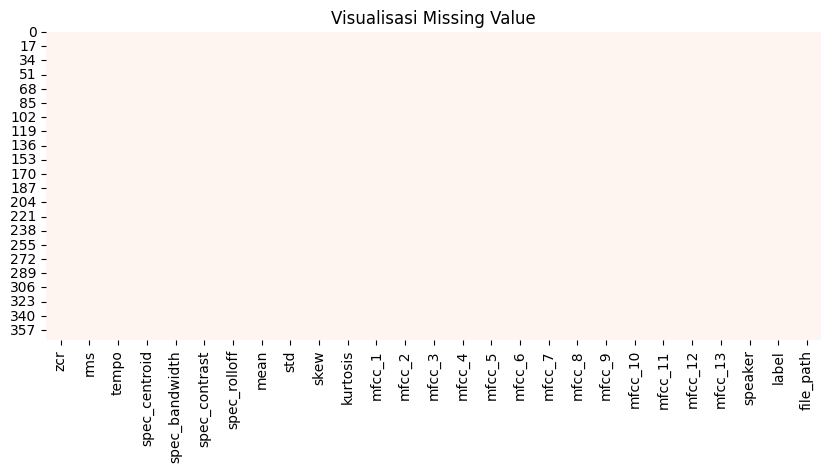

In [14]:
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, cmap='Reds')
plt.title("Visualisasi Missing Value")
plt.show()

**cek outlayer**

In [15]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
outlier_counts = {}

# Loop tiap kolom numerik
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outlier_mask = (df[col] < lower) | (df[col] > upper)
    outlier_counts[col] = outlier_mask.sum()

outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Jumlah Outlier'])
outlier_df.sort_values(by='Jumlah Outlier', ascending=False)

,Jumlah Outlier
mean,56
mfcc_3,22
kurtosis,19
spec_bandwidth,17
spec_rolloff,15
spec_centroid,13
zcr,10
skew,10
mfcc_9,9
mfcc_2,9


Setelah dilakukan analisis outlier menggunakan metode IQR, ditemukan bahwa beberapa fitur seperti mean, mfcc_3, dan kurtosis memiliki jumlah outlier yang cukup banyak. Namun, karena outlier tersebut kemungkinan merupakan variasi alami dari karakteristik sinyal suara, data tidak dihapus untuk menjaga keutuhan informasi. Sebagai gantinya, dilakukan proses normalisasi menggunakan RobustScaler agar distribusi setiap fitur menjadi lebih seimbang tanpa menghilangkan pengaruh data ekstrem. RobustScaler dipilih karena metode ini menggunakan median dan interquartile range (IQR) sehingga lebih tahan terhadap outlier dibandingkan normalisasi konvensional seperti MinMaxScaler atau StandardScaler.

**Distribusi fitur utama**

<Figure size 1200x600 with 0 Axes>

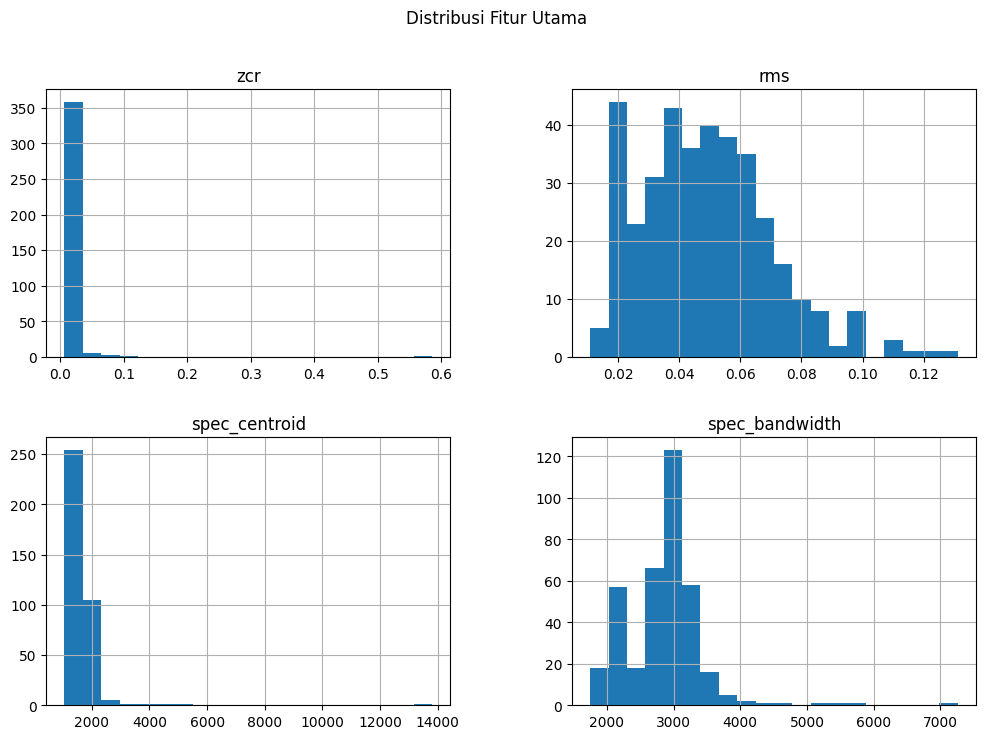

In [16]:
plt.figure(figsize=(12, 6))
df[['zcr', 'rms', 'spec_centroid', 'spec_bandwidth']].hist(bins=20, figsize=(12,8))
plt.suptitle("Distribusi Fitur Utama")
plt.show()

**korelasi antar fitur**

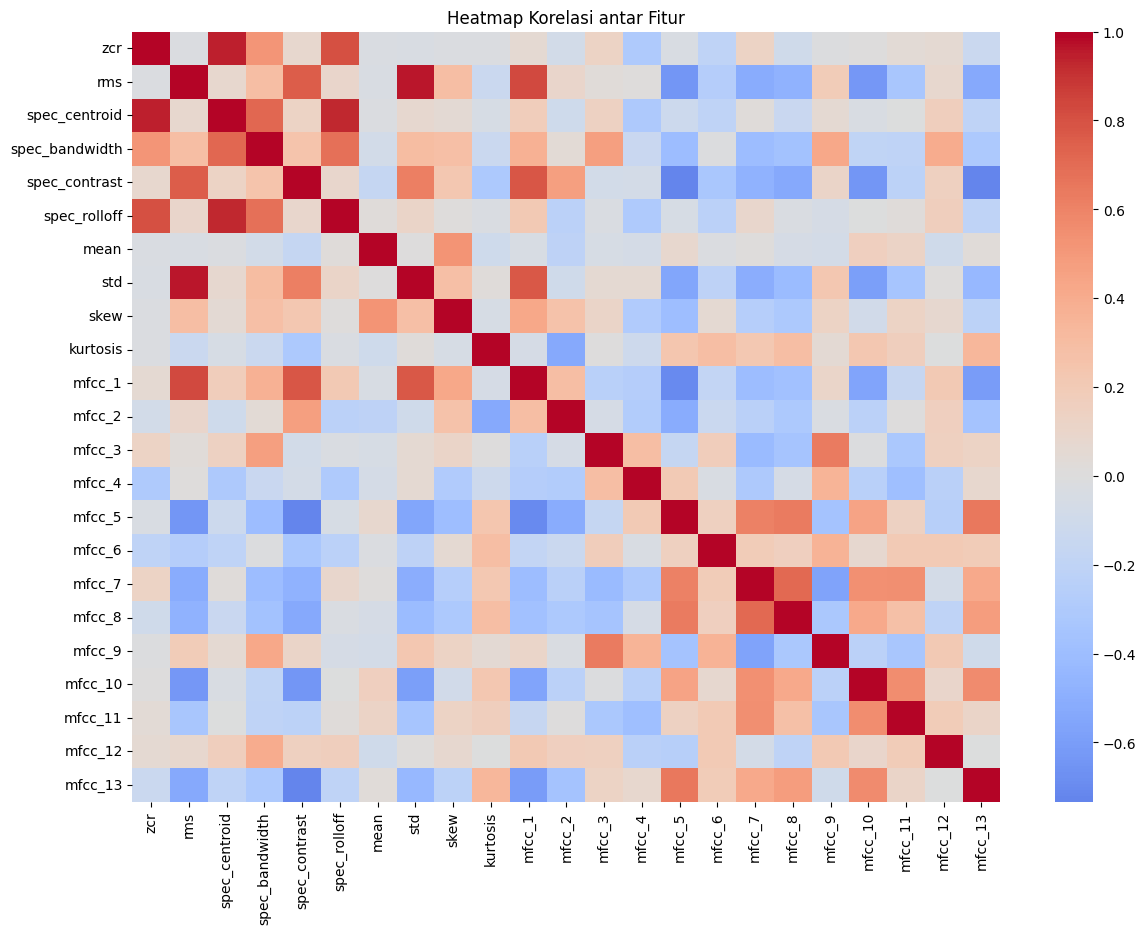

In [17]:
plt.figure(figsize=(14, 10))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title("Heatmap Korelasi antar Fitur")
plt.show()

Sebanyak 21 fitur utama dipilih berdasarkan hasil analisis korelasi antar fitur dan relevansinya terhadap karakteristik sinyal audio. Pemilihan ini mempertimbangkan representasi dari aspek temporal, spektral, dan statistik suara. Fitur zcr dan rms dipertahankan karena menggambarkan dinamika energi dan frekuensi dasar sinyal. Dari kelompok fitur spektral, hanya spec_centroid, spec_contrast, dan spec_rolloff yang diambil untuk menghindari redundansi akibat korelasi tinggi dengan fitur sejenis. Selain itu, fitur statistik (mean, std, skew, kurtosis) dimasukkan untuk menangkap distribusi dan variasi nilai sinyal. Seluruh 13 koefisien MFCC (mfcc_1–mfcc_13) juga digunakan karena mampu merepresentasikan karakteristik frekuensi yang relevan bagi persepsi pendengaran manusia. Dengan demikian, kombinasi 21 fitur ini dinilai cukup informatif dan efisien untuk proses pemodelan.

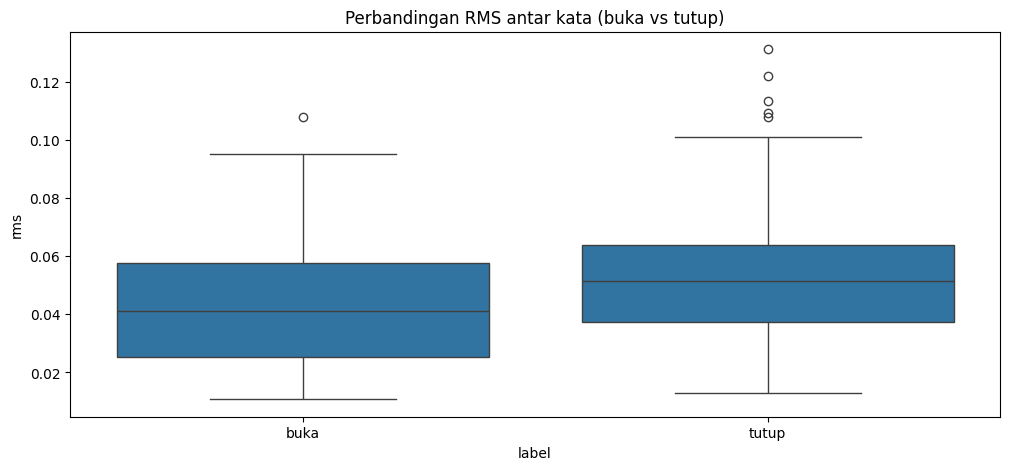

In [18]:
if 'label' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='label', y='rms', data=df)
    plt.title("Perbandingan RMS antar kata (buka vs tutup)")
    plt.show()

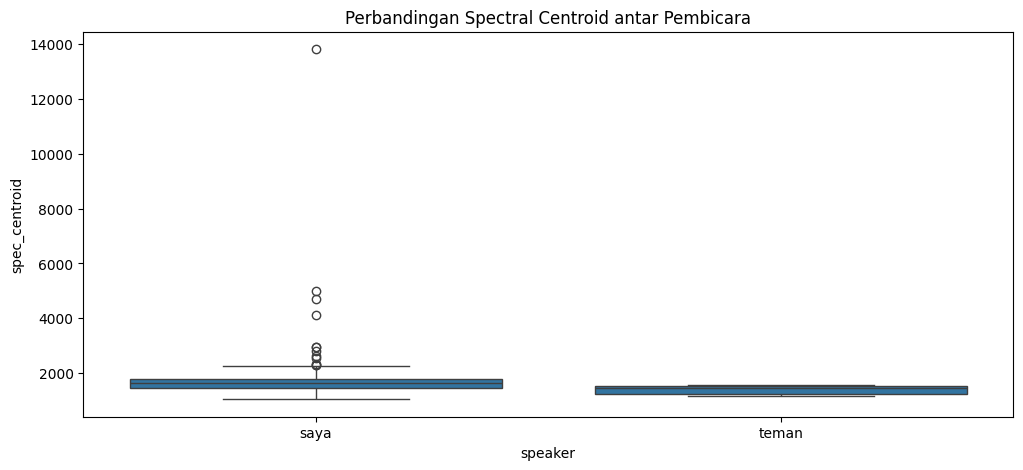

In [19]:
if 'speaker' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='speaker', y='spec_centroid', data=df)
    plt.title("Perbandingan Spectral Centroid antar Pembicara")
    plt.show()

#### **4.preprosessing**

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv("ekstraksi_fitur_suara.csv")

print("Ukuran awal dataset:", df.shape)
df['spec_bandwidth'] = df['spec_bandwidth'].astype(float)
df['spec_rolloff'] = df['spec_rolloff'].astype(float)

display(df.head())

Ukuran awal dataset: (369, 27)


,zcr,rms,tempo,spec_centroid,spec_bandwidth,spec_contrast,spec_rolloff,mean,std,skew,...,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,speaker,label,file_path
0,0.031096,0.077008,[303.99816176],1971.563441,3212.080263,19.746896,3617.578125,0.000004,0.107378,1.221425,...,0.993255,0.251915,5.557098,-7.657348,6.288062,0.897784,-12.901854,saya,buka,dataset/train\saya\buka\buka_1 (2).wav
1,0.024106,0.095067,[166.70866935],1946.156207,3328.419830,19.148309,3524.157151,0.000151,0.126469,0.824466,...,6.570087,5.286549,7.126675,-8.592355,1.969883,11.492401,-14.198255,saya,buka,dataset/train\saya\buka\buka_1.wav
2,0.028622,0.051543,[287.109375],1961.685899,3202.618051,19.316381,3983.184425,-0.000011,0.074131,1.364824,...,10.303352,4.179083,-0.241050,-2.061037,13.400628,1.011641,-20.812042,saya,buka,dataset/train\saya\buka\buka_10 (2).wav
3,0.028851,0.065145,[198.76802885],1786.679298,3059.365229,19.464844,3177.469675,0.000029,0.087380,1.388188,...,9.829638,-2.206978,-9.136992,-13.432102,-1.176778,6.743266,-7.540455,saya,buka,dataset/train\saya\buka\buka_10.wav
4,0.036051,0.080667,[120.18531977],2149.597011,3334.384832,19.373303,4163.803711,0.000009,0.118984,0.802815,...,8.861814,14.030582,-7.373435,-1.762983,12.971463,6.720855,-18.296100,saya,buka,dataset/train\saya\buka\buka_11 (2).wav


**Cek dan Tangani Missing Value**

karena dalam proses EDA tadi tidsak ditemukan adanya missing value maka saya skip

**Deteksi & Tangani Outlier**

In [23]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
outlier_counts = {}

# Loop tiap kolom numerik
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outlier_mask = (df[col] < lower) | (df[col] > upper)
    outlier_counts[col] = outlier_mask.sum()

outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Jumlah Outlier'])
outlier_df.sort_values(by='Jumlah Outlier', ascending=False)

,Jumlah Outlier
mean,56
mfcc_3,22
kurtosis,19
spec_bandwidth,17
spec_rolloff,15
spec_centroid,13
zcr,10
skew,10
mfcc_9,9
mfcc_2,9


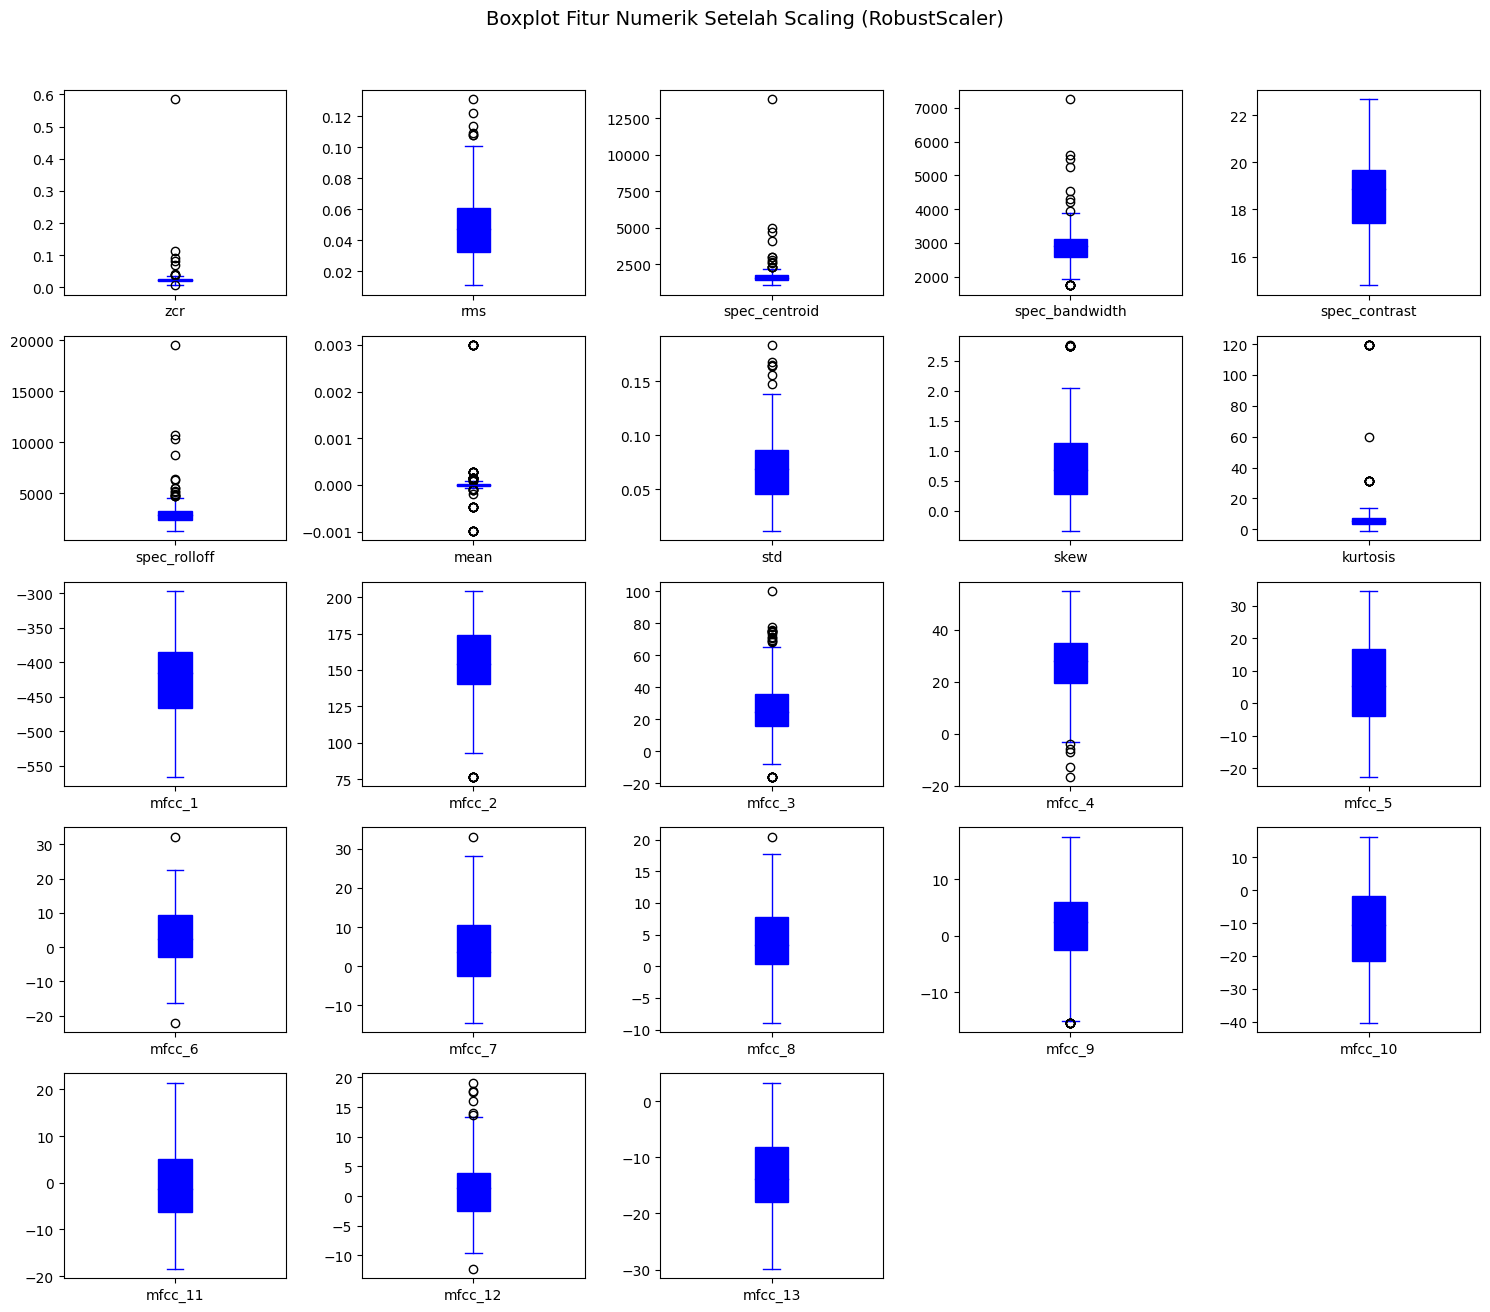

In [24]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

df[num_cols].plot(
    kind='box',
    subplots=True,
    layout=(6, 5),     
    figsize=(15, 15),
    sharex=False,
    sharey=False,
    color='blue',
    patch_artist=True
)

plt.suptitle('Boxplot Fitur Numerik Setelah Scaling (RobustScaler)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


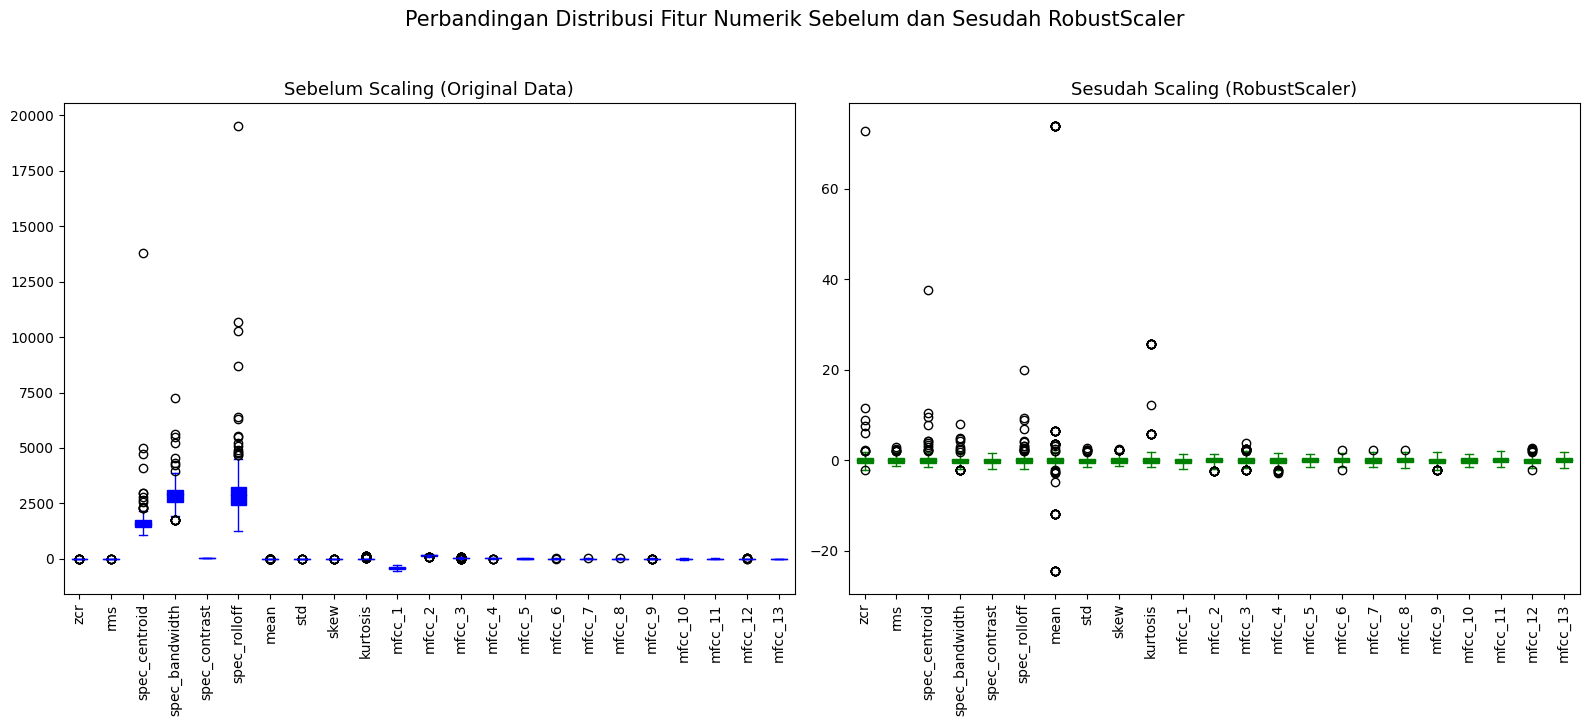

In [25]:
df_original = df.copy()
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Boxplot sebelum scaling
df_original[num_cols].plot(
    kind='box',
    subplots=False,
    ax=axes[0],
    color='blue',
    patch_artist=True
)
axes[0].set_title('Sebelum Scaling (Original Data)', fontsize=13)
axes[0].tick_params(axis='x', rotation=90)

df_scaled[num_cols].plot(
    kind='box',
    subplots=False,
    ax=axes[1],
    color='green',
    patch_artist=True
)
axes[1].set_title('Sesudah Scaling (RobustScaler)', fontsize=13)
axes[1].tick_params(axis='x', rotation=90)

plt.suptitle('Perbandingan Distribusi Fitur Numerik Sebelum dan Sesudah RobustScaler', fontsize=15, y=1.03)
plt.tight_layout()
plt.show()


Setelah penerapan RobustScaler, persebaran data menjadi lebih seimbang dan tidak terlalu dipengaruhi oleh nilai ekstrem. Meskipun beberapa titik masih terdeteksi sebagai outlier, skala nilai keseluruhan sudah tereduksi secara signifikan sehingga lebih stabil untuk digunakan pada proses pelatihan model.

In [26]:
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

def count_outliers_iqr(data):
    Q1, Q3 = data.quantile(0.25), data.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return ((data < lower) | (data > upper)).sum()

comparison = pd.DataFrame({
    "Sebelum Scaling": count_outliers_iqr(df[num_cols]),
    "Sesudah RobustScaler": count_outliers_iqr(df_scaled)
})

print(comparison)

                Sebelum Scaling  Sesudah RobustScaler
zcr                          10                    10
rms                           6                     6
spec_centroid                13                    13
spec_bandwidth               17                    17
spec_contrast                 0                     0
spec_rolloff                 15                    15
mean                         56                    56
std                           7                     7
skew                         10                    10
kurtosis                     19                    19
mfcc_1                        0                     0
mfcc_2                        9                     9
mfcc_3                       22                    22
mfcc_4                        5                     5
mfcc_5                        0                     0
mfcc_6                        2                     2
mfcc_7                        1                     1
mfcc_8                      

Berdasarkan hasil perhitungan jumlah outlier sebelum dan sesudah proses scaling menggunakan RobustScaler, diketahui bahwa jumlah outlier pada setiap fitur tidak mengalami perubahan. Hal ini menunjukkan bahwa RobustScaler tidak menghilangkan data outlier, melainkan menormalkan skala data dengan menggunakan median dan interkuartil (IQR) sehingga pengaruh nilai ekstrem menjadi lebih kecil terhadap distribusi keseluruhan. Dengan demikian, meskipun outlier tetap ada, efeknya terhadap proses pelatihan model menjadi lebih stabil dan tidak mendominasi seperti sebelum dilakukan scaling.

In [27]:
print("=== Statistik Sebelum Scaling ===")
print(df[num_cols].describe().T[['mean', 'std', 'min', 'max']])

print("\n=== Statistik Sesudah RobustScaler ===")
print(df_scaled.describe().T[['mean', 'std', 'min', 'max']])

=== Statistik Sebelum Scaling ===
                       mean          std          min           max
zcr                0.024715     0.030650     0.006529      0.585637
rms                0.048675     0.021204     0.010810      0.131164
spec_centroid   1648.766727   745.942448  1055.410890  13800.443171
spec_bandwidth  2853.868778   571.084674  1748.447899   7260.743112
spec_contrast     18.672939     1.468317    14.787431     22.680890
spec_rolloff    2961.213764  1321.457663  1263.281250  19539.449369
mean               0.000047     0.000501    -0.000992      0.002999
std                0.068750     0.030500     0.011405      0.183844
skew               0.739074     0.645404    -0.337228      2.759892
kurtosis           8.736862    18.413122    -1.256984    119.450213
mfcc_1          -426.077906    55.490277  -566.471860   -296.360380
mfcc_2           152.104256    26.250731    76.421844    204.424350
mfcc_3            26.544227    19.090155   -16.036188    100.368040
mfcc_4        

In [28]:
print("=== Contoh 5 Baris Sebelum Scaling ===")
print(df[num_cols].head())

print("\n=== Contoh 5 Baris Sesudah Scaling ===")
print(df_scaled.head())

=== Contoh 5 Baris Sebelum Scaling ===
        zcr       rms  spec_centroid  spec_bandwidth  spec_contrast  \
0  0.031096  0.077008    1971.563441     3212.080263      19.746896   
1  0.024106  0.095067    1946.156207     3328.419830      19.148309   
2  0.028622  0.051543    1961.685899     3202.618051      19.316381   
3  0.028851  0.065145    1786.679298     3059.365229      19.464844   
4  0.036051  0.080667    2149.597011     3334.384832      19.373303   

   spec_rolloff      mean       std      skew   kurtosis  ...     mfcc_4  \
0   3617.578125  0.000004  0.107378  1.221425   8.486442  ...   8.535300   
1   3524.157151  0.000151  0.126469  0.824466  10.367428  ...  18.738329   
2   3983.184425 -0.000011  0.074131  1.364824   7.750736  ...  11.875400   
3   3177.469675  0.000029  0.087380  1.388188   8.613768  ...  10.738055   
4   4163.803711  0.000009  0.118984  0.802815   5.025326  ...  -7.165276   

      mfcc_5     mfcc_6     mfcc_7     mfcc_8    mfcc_9    mfcc_10    mfcc_11

**encoding**

In [29]:
from sklearn.preprocessing import LabelEncoder

le_speaker = LabelEncoder()
le_label = LabelEncoder()

df['speaker'] = le_speaker.fit_transform(df['speaker'])
df['label'] = le_label.fit_transform(df['label'])

print("✅ Label encoding selesai.\n")
print("📌 Mapping speaker:")
print(dict(zip(le_speaker.classes_, le_speaker.transform(le_speaker.classes_))))
print("\n📌 Mapping label:")
print(dict(zip(le_label.classes_, le_label.transform(le_label.classes_))))

✅ Label encoding selesai.

📌 Mapping speaker:
{'saya': 0, 'teman': 1}

📌 Mapping label:
{'buka': 0, 'tutup': 1}


In [30]:
df_scaled

,zcr,rms,spec_centroid,spec_bandwidth,spec_contrast,spec_rolloff,mean,std,skew,kurtosis,...,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,1.072609,1.031192,1.268750,0.532516,0.391800,0.906697,0.087915,0.939025,0.638637,0.748368,...,-1.248148,-0.527866,0.242931,-0.198970,-0.410708,0.374808,0.147265,0.675977,-0.064073,0.102586
1,0.168561,1.657417,1.190594,0.746328,0.126476,0.795082,3.696722,1.406597,0.173169,1.172568,...,-0.590539,-0.615455,0.056176,0.227901,0.261943,0.561147,0.100202,0.295603,1.601489,-0.030745
2,0.752556,0.148150,1.238365,0.515126,0.200974,1.343505,-0.283603,0.124729,0.806784,0.582452,...,-1.032871,-0.830635,0.665027,0.513659,0.113980,-0.313546,0.428951,1.302501,-0.046174,-0.710956
3,0.782281,0.619813,0.700024,0.251852,0.266780,0.380877,0.698351,0.449231,0.834180,0.777082,...,-1.106175,0.225690,-0.138595,0.477399,-0.739227,-1.369670,-0.143403,0.018423,0.854886,0.653992
4,1.713461,1.158061,1.816402,0.757290,0.226204,1.559300,0.208997,1.223272,0.147782,-0.032183,...,-2.260086,-1.134810,-0.781525,0.403319,1.430186,-1.160301,0.443953,1.264697,0.851362,-0.452198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,-0.315377,-0.213149,-0.194917,-1.126681,-1.009695,0.361152,73.996216,0.064430,2.425390,5.821709,...,-0.561732,0.553803,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382
365,-0.315377,-0.213149,-0.194917,-1.126681,-1.009695,0.361152,73.996216,0.064430,2.425390,5.821709,...,-0.561732,0.553803,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382
366,-0.315377,-0.213149,-0.194917,-1.126681,-1.009695,0.361152,73.996216,0.064430,2.425390,5.821709,...,-0.561732,0.553803,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382
367,-0.315377,-0.213149,-0.194917,-1.126681,-1.009695,0.361152,73.996216,0.064430,2.425390,5.821709,...,-0.561732,0.553803,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382


In [31]:
df_scaled = df_scaled.copy() 
df_scaled['speaker'] = df['speaker'].values
df_scaled['label'] = df['label'].values

df_scaled.head()


,zcr,rms,spec_centroid,spec_bandwidth,spec_contrast,spec_rolloff,mean,std,skew,kurtosis,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,speaker,label
0,1.072609,1.031192,1.268750,0.532516,0.391800,0.906697,0.087915,0.939025,0.638637,0.748368,...,0.242931,-0.198970,-0.410708,0.374808,0.147265,0.675977,-0.064073,0.102586,0,0
1,0.168561,1.657417,1.190594,0.746328,0.126476,0.795082,3.696722,1.406597,0.173169,1.172568,...,0.056176,0.227901,0.261943,0.561147,0.100202,0.295603,1.601489,-0.030745,0,0
2,0.752556,0.148150,1.238365,0.515126,0.200974,1.343505,-0.283603,0.124729,0.806784,0.582452,...,0.665027,0.513659,0.113980,-0.313546,0.428951,1.302501,-0.046174,-0.710956,0,0
3,0.782281,0.619813,0.700024,0.251852,0.266780,0.380877,0.698351,0.449231,0.834180,0.777082,...,-0.138595,0.477399,-0.739227,-1.369670,-0.143403,0.018423,0.854886,0.653992,0,0
4,1.713461,1.158061,1.816402,0.757290,0.226204,1.559300,0.208997,1.223272,0.147782,-0.032183,...,-0.781525,0.403319,1.430186,-1.160301,0.443953,1.264697,0.851362,-0.452198,0,0


**Pisahkan fitur dan target**

In [48]:
feature_cols = [
    'zcr', 'rms',
    'spec_centroid', 'spec_contrast',
    'mean', 'std', 'skew', 'kurtosis',
    'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6',
    'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13'
]

X = df_scaled[feature_cols]
y_speaker = df_scaled['speaker']
y_label = df_scaled['label']

print("Jumlah fitur untuk speaker:", len(feature_cols))

Jumlah fitur untuk speaker: 21


In [49]:
df_scaled.head()

,zcr,rms,spec_centroid,spec_bandwidth,spec_contrast,spec_rolloff,mean,std,skew,kurtosis,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,speaker,label
0,1.072609,1.031192,1.268750,0.532516,0.391800,0.906697,0.087915,0.939025,0.638637,0.748368,...,0.242931,-0.198970,-0.410708,0.374808,0.147265,0.675977,-0.064073,0.102586,0,0
1,0.168561,1.657417,1.190594,0.746328,0.126476,0.795082,3.696722,1.406597,0.173169,1.172568,...,0.056176,0.227901,0.261943,0.561147,0.100202,0.295603,1.601489,-0.030745,0,0
2,0.752556,0.148150,1.238365,0.515126,0.200974,1.343505,-0.283603,0.124729,0.806784,0.582452,...,0.665027,0.513659,0.113980,-0.313546,0.428951,1.302501,-0.046174,-0.710956,0,0
3,0.782281,0.619813,0.700024,0.251852,0.266780,0.380877,0.698351,0.449231,0.834180,0.777082,...,-0.138595,0.477399,-0.739227,-1.369670,-0.143403,0.018423,0.854886,0.653992,0,0
4,1.713461,1.158061,1.816402,0.757290,0.226204,1.559300,0.208997,1.223272,0.147782,-0.032183,...,-0.781525,0.403319,1.430186,-1.160301,0.443953,1.264697,0.851362,-0.452198,0,0


In [51]:
df_scaled[feature_cols].describe().T[['mean', 'std']]

,mean,std
zcr,0.247307,3.963930
rms,0.048683,0.735287
spec_centroid,0.275788,2.294608
spec_contrast,-0.084233,0.650833
mean,1.154455,12.358058
std,-0.007077,0.747022
skew,0.073039,0.756790
kurtosis,0.804843,4.152525
mfcc_1,-0.125364,0.680384
mfcc_2,-0.062592,0.780527


In [52]:
df_processed = X.copy()
df_processed['speaker'] = y_speaker.values
df_processed['label'] = y_label.values

# Simpan ke CSV
df_processed.to_csv("data_preprocessed.csv", index=False)

print("✅ Hasil preprocessing berhasil disimpan ke 'data_preprocessed.csv'")
print(f"Ukuran data: {df_processed.shape}")

✅ Hasil preprocessing berhasil disimpan ke 'data_preprocessed.csv'
Ukuran data: (369, 23)


### **5. Modeling klasifikasi buka-tutup**

Pada tahap ini digunakan model klasifikasi ringan seperti Random Forest atau XGBoost, mengingat ukuran dataset yang relatif kecil. Kedua model ini dipilih karena memiliki performa baik dalam menangani data dengan jumlah terbatas serta mampu memberikan hasil prediksi yang stabil dan akurat.

### **modeling klasifikasi suara saya/teman**

**Model 1 — Speech Command Recognition**

In [79]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import pandas as pd

In [80]:
df_kata_speaker = pd.read_csv("data_preprocessed.csv")

In [81]:
df_kata_speaker

,zcr,rms,spec_centroid,spec_contrast,mean,std,skew,kurtosis,mfcc_1,mfcc_2,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,speaker,label
0,1.072609,1.031192,1.268750,0.391800,0.087915,0.939025,0.638637,0.748368,1.020380,0.257616,...,0.242931,-0.198970,-0.410708,0.374808,0.147265,0.675977,-0.064073,0.102586,0,0
1,0.168561,1.657417,1.190594,0.126476,3.696722,1.406597,0.173169,1.172568,0.867127,0.149612,...,0.056176,0.227901,0.261943,0.561147,0.100202,0.295603,1.601489,-0.030745,0,0
2,0.752556,0.148150,1.238365,0.200974,-0.283603,0.124729,0.806784,0.582452,0.470446,0.397161,...,0.665027,0.513659,0.113980,-0.313546,0.428951,1.302501,-0.046174,-0.710956,0,0
3,0.782281,0.619813,0.700024,0.266780,0.698351,0.449231,0.834180,0.777082,0.378174,0.627608,...,-0.138595,0.477399,-0.739227,-1.369670,-0.143403,0.018423,0.854886,0.653992,0,0
4,1.713461,1.158061,1.816402,0.226204,0.208997,1.223272,0.147782,-0.032183,0.856057,0.008094,...,-0.781525,0.403319,1.430186,-1.160301,0.443953,1.264697,0.851362,-0.452198,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,-0.315377,-0.213149,-0.194917,-1.009695,73.996216,0.064430,2.425390,5.821709,-0.218015,-1.732196,...,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382,1,0
365,-0.315377,-0.213149,-0.194917,-1.009695,73.996216,0.064430,2.425390,5.821709,-0.218015,-1.732196,...,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382,1,0
366,-0.315377,-0.213149,-0.194917,-1.009695,73.996216,0.064430,2.425390,5.821709,-0.218015,-1.732196,...,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382,1,0
367,-0.315377,-0.213149,-0.194917,-1.009695,73.996216,0.064430,2.425390,5.821709,-0.218015,-1.732196,...,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382,1,0


In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_label, test_size=0.2, random_state=42, stratify=y_label
)

pipeline_label = Pipeline([
    ('clf', RandomForestClassifier(
        random_state=42,
        n_estimators=300,
        max_depth=10
    ))
])

pipeline_label.fit(X_train, y_train)

y_pred = pipeline_label.predict(X_test)

print("\n=== Speech Command Recognition ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Speech Command Recognition ===
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.97      1.00      0.99        36

    accuracy                           0.99        74
   macro avg       0.99      0.99      0.99        74
weighted avg       0.99      0.99      0.99        74

Confusion Matrix:
 [[37  1]
 [ 0 36]]


**Model 2 — Speaker Recognition**

In [83]:
df_kata_speaker = pd.read_csv("data_preprocessed.csv")

In [84]:
df_kata_speaker

,zcr,rms,spec_centroid,spec_contrast,mean,std,skew,kurtosis,mfcc_1,mfcc_2,...,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,speaker,label
0,1.072609,1.031192,1.268750,0.391800,0.087915,0.939025,0.638637,0.748368,1.020380,0.257616,...,0.242931,-0.198970,-0.410708,0.374808,0.147265,0.675977,-0.064073,0.102586,0,0
1,0.168561,1.657417,1.190594,0.126476,3.696722,1.406597,0.173169,1.172568,0.867127,0.149612,...,0.056176,0.227901,0.261943,0.561147,0.100202,0.295603,1.601489,-0.030745,0,0
2,0.752556,0.148150,1.238365,0.200974,-0.283603,0.124729,0.806784,0.582452,0.470446,0.397161,...,0.665027,0.513659,0.113980,-0.313546,0.428951,1.302501,-0.046174,-0.710956,0,0
3,0.782281,0.619813,0.700024,0.266780,0.698351,0.449231,0.834180,0.777082,0.378174,0.627608,...,-0.138595,0.477399,-0.739227,-1.369670,-0.143403,0.018423,0.854886,0.653992,0,0
4,1.713461,1.158061,1.816402,0.226204,0.208997,1.223272,0.147782,-0.032183,0.856057,0.008094,...,-0.781525,0.403319,1.430186,-1.160301,0.443953,1.264697,0.851362,-0.452198,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,-0.315377,-0.213149,-0.194917,-1.009695,73.996216,0.064430,2.425390,5.821709,-0.218015,-1.732196,...,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382,1,0
365,-0.315377,-0.213149,-0.194917,-1.009695,73.996216,0.064430,2.425390,5.821709,-0.218015,-1.732196,...,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382,1,0
366,-0.315377,-0.213149,-0.194917,-1.009695,73.996216,0.064430,2.425390,5.821709,-0.218015,-1.732196,...,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382,1,0
367,-0.315377,-0.213149,-0.194917,-1.009695,73.996216,0.064430,2.425390,5.821709,-0.218015,-1.732196,...,-0.025134,0.632241,0.381759,-0.855267,0.698849,0.608815,-0.722789,0.585382,1,0


In [85]:
print(f"Jumlah data (speaker): {len(df_orang)}")
print(f"Jumlah fitur (speaker): {X_speaker.shape[1]}")

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y_speaker, test_size=0.2, random_state=42, stratify=y_speaker
)

pipeline_speaker = Pipeline([ 
    ('clf', RandomForestClassifier(
        random_state=42,
        n_estimators=300,
        max_depth=10
    ))
])

pipeline_speaker.fit(X_train_s, y_train_s)

y_pred_s = pipeline_speaker.predict(X_test_s)

print("\n=== Speaker Recognition ===")
print(classification_report(y_test_s, y_pred_s))
print("Confusion Matrix:\n", confusion_matrix(y_test_s, y_pred_s))

Jumlah data (speaker): 369
Jumlah fitur (speaker): 13

=== Speaker Recognition ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        57
           1       1.00      1.00      1.00        17

    accuracy                           1.00        74
   macro avg       1.00      1.00      1.00        74
weighted avg       1.00      1.00      1.00        74

Confusion Matrix:
 [[57  0]
 [ 0 17]]


**Prediksi Gabungan Saat Sistem Jalan**

In [86]:
def predict_audio(input_features, pipeline_speaker, pipeline_label, le_speaker, le_label):
    input_array = [input_features]

    speaker_pred_enc = pipeline_speaker.predict(input_array)[0]
    speaker_prob = pipeline_speaker.predict_proba(input_array)[0].max()

    if speaker_prob < 0.7:
        return "Pembicara tidak dikenal"

    speaker_pred_name = le_speaker.inverse_transform([speaker_pred_enc])[0]

    if speaker_pred_name == "teman": 
        return "Suara teman, abaikan perintah"

    label_pred_enc = pipeline_label.predict(input_array)[0]
    label_pred_name = le_label.inverse_transform([label_pred_enc])[0]

    return f"Suara saya, kata: {label_pred_name}"


In [88]:
import pickle
import joblib

# Simpan pipeline (sudah termasuk scaler)
with open('model_label.pkl', 'wb') as f:
    pickle.dump(pipeline_label, f)

with open('model_speaker.pkl', 'wb') as f:
    pickle.dump(pipeline_speaker, f)

# Simpan LabelEncoders
joblib.dump(le_label, 'le_label.pkl')
joblib.dump(le_speaker, 'le_speaker.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("✅ Semua file berhasil disimpan:")
print("   - model_label.pkl   (Pipeline buka/tutup termasuk scaler)")
print("   - model_speaker.pkl (Pipeline deteksi pembicara termasuk scaler)")
print("   - le_label.pkl      (Encoder label buka/tutup)")
print("   - le_speaker.pkl    (Encoder pembicara)")
print("   - scaler.pkl")

✅ Semua file berhasil disimpan:
   - model_label.pkl   (Pipeline buka/tutup termasuk scaler)
   - model_speaker.pkl (Pipeline deteksi pembicara termasuk scaler)
   - le_label.pkl      (Encoder label buka/tutup)
   - le_speaker.pkl    (Encoder pembicara)
   - scaler.pkl
